## Гавриков Арсений МСКМ-201

Основываясь на примере https://github.com/ev-br/np_cy/tree/master/planet
- реализовать интегрирование уравнений движения в задаче небесной механики методом Рунге-Кутта не ниже второго порядка
- двумя способами: с использованием Cython и Numba
- предусмотреть проверку точности выполнения законов сохранения
- визуализировать траекторию не интервале времен не менее трех периодов.

In [1]:
import numpy as np

# Part 1. Cython

In [2]:
%load_ext cython

In [3]:
%%cython -a

from libc.math cimport sqrt

cimport cython

cdef class Planet(object):
    cdef public double x, y, z, vx, vy, vz, m, energy, Lx, Ly, Lz, t
    def __init__(self):
        self.x = 1.0
        self.y = 0.0
        self.z = 0.0
        self.vx = 0.0
        self.vy = 0.0
        self.vz = 1.0
        self.energy = -0.5
        self.Lx = 0.0
        self.Ly = -1.0
        self.Lz = 0.0
        self.t = 0.0
        self.m = 1.0

@cython.cdivision(True)
cdef void single_step(Planet planet,
                      double dt) nogil:
    """Make a single step in time, t -> t+dt."""
    # Gravitational force pulls towards origin
    cdef double r, r3, M
    r = sqrt(planet.x**2 + planet.y**2 + planet.z**2)
    r3 = r*r*r   # XXX: check generated C code
    
    # update position
    planet.x += rungekutt(planet.vx, dt)
    planet.y += rungekutt(planet.vy, dt)
    planet.z += rungekutt(planet.vz, dt)
    
    Fx = -planet.x / r3
    Fy = -planet.y / r3
    Fz = -planet.z / r3
    
    # update velocity
    m = planet.m
    planet.vx += rungekutt(Fx/m, dt)
    planet.vy += rungekutt(Fy/m, dt)
    planet.vz += rungekutt(Fz/m, dt)
    
    planet.energy = (planet.vx**2 + planet.vy**2 + planet.vz**2)/2 - 1/r
        
    planet.Lx = planet.y * planet.vz - planet.vy * planet.z
    planet.Ly = -planet.x * planet.vz + planet.vx * planet.z
    planet.Lz = planet.x * planet.vy - planet.vx * planet.y
    
    planet.t += dt

cdef double f(double y) nogil:
    return y

cdef double rungekutt(double y, double dt) nogil:
    cdef double k1, k2, k3, k4
    k1 = f(y)
    k2 = f(y + dt*k1/2)
    k3 = f(y + dt*k2/2)
    k4 = f(y + dt*k3)
    return (k1 + 2*k2 + 2*k3 + k4)*dt/6

@cython.cdivision(True)
def propagate(planet,
              double time_span,
              int num_steps):
    """Make a number of time steps."""

    cdef double dt = time_span / num_steps
    cdef int j
    
    for j in range(num_steps):
        single_step(planet, dt)
        

In [4]:
planet = Planet()
%timeit propagate(planet, 1, 100)

22.8 µs ± 850 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
planet = Planet()

x, y, z = [], [], []
vx, vy, vz = [], [], []
Lx, Ly, Lz = [], [], []
t = []
energy = []
for i in range(12000):
    propagate(planet, 0.01, 1)
    x.append(planet.x)
    y.append(planet.y)
    z.append(planet.z)
    
    vx.append(planet.vx)
    vy.append(planet.vy)
    vz.append(planet.vz)
    
    Lx.append(planet.Lx)
    Ly.append(planet.Ly)
    Lz.append(planet.Lz)
    
    t.append(planet.t)
    
    energy.append(planet.energy)

In [6]:
L = (np.array(Lx)**2 +  np.array(Ly)**2 +  np.array(Lz)**2)**0.5

In [7]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,6

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Законы сохранения - закон сохранения импульса и энергии

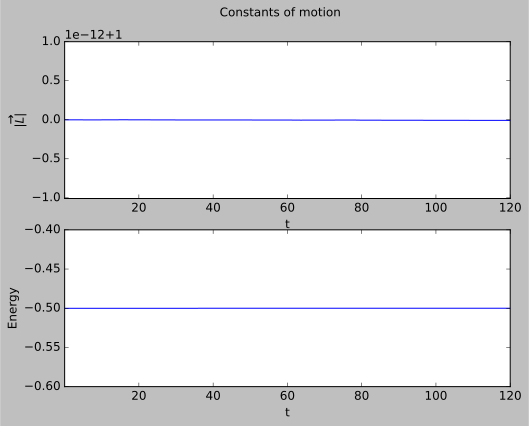

In [8]:
with plt.style.context('classic'): 
    fig, axs = plt.subplots(2)
    fig.suptitle('Constants of motion')

    axs[0].plot(t, L)
    axs[1].plot(t, energy)
    plt.ylim(-0.6, -0.4)

    ylabels = ['$|\overrightarrow{L}|$', 'Energy']
    i = 0
    for ax in axs.flat:
        ax.set(xlabel='t', ylabel=r'{}'.format(ylabels[i]))
        i += 1

## Фазовая плоскость

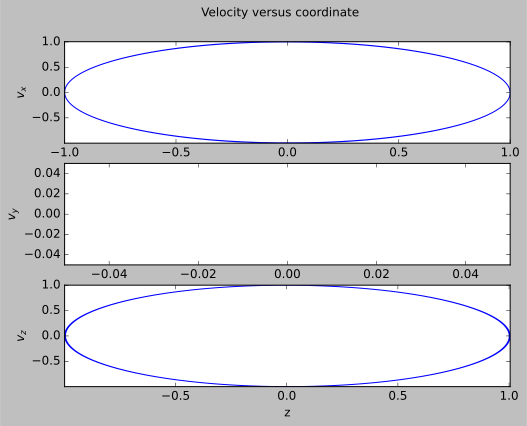

In [9]:
with plt.style.context('classic'): 
    fig, axs = plt.subplots(3)
    fig.suptitle('Velocity versus coordinate')

    axs[0].plot(x, vx)
    axs[1].plot(y, vy)
    axs[2].plot(z, vz)

    axs[0].set(xlabel='x', ylabel=r'$v_x$')
    axs[1].set(xlabel='y', ylabel=r'$v_y$')
    axs[2].set(xlabel='z', ylabel=r'$v_z$')

## Траектории по координатам

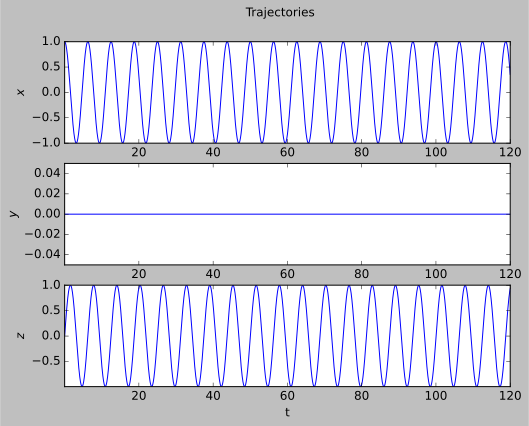

In [10]:
with plt.style.context('classic'): 
    fig, axs = plt.subplots(3)
    fig.suptitle('Trajectories')

    axs[0].plot(t, x)
    axs[1].plot(t, y)
    axs[2].plot(t, z)

    axs[0].set(xlabel='t', ylabel=r'$x$')
    axs[1].set(xlabel='t', ylabel=r'$y$')
    axs[2].set(xlabel='t', ylabel=r'$z$')

## Траектория

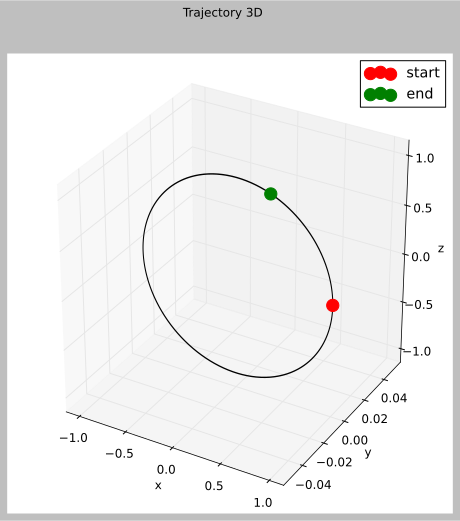

In [11]:
with plt.style.context('classic'): 
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle('Trajectory 3D')


    ax.scatter(x[0], y[0], z[0], s=150, color='red', label='start')

    ax.scatter(x[-1], y[-1], z[-1], s=150, color='green', label='end')

    ax.plot3D(x, y, z, 'black')
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    ax.legend()

# Part 2. Numba


In [12]:
import numba
from numba import float64

spec = [
    ('x', float64),
    ('y', float64),
    ('z', float64),
    ('vx', float64),
    ('vy', float64),
    ('vz', float64),
    ('energy', float64),
    ('Lx', float64),
    ('Ly', float64),
    ('Lz', float64),
    ('t', float64),
    ('m', float64),
]

@numba.jitclass(spec)
class Planet(object):
    """A class to store a planet's parameters."""
    def __init__(self):
        self.x = 1.0
        self.y = 0.0
        self.z = 0.0
        self.vx = 0.0
        self.vy = 0.0
        self.vz = 1.0
        self.energy = -0.5
        self.Lx = 0.0
        self.Ly = -1.0
        self.Lz = 0.0
        self.t = 0.0
        self.m = 1.0

C:\Users\Arsenii\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.


In [13]:
from math import sqrt

@numba.jit(nopython=True)
def numba_single_step(planet, dt):
    """Make a single step in time, t -> t+dt."""
    
    # Gravitational force pulls towards origin
    r = sqrt(planet.x**2 + planet.y**2 + planet.z**2)
    r3 = r**3
    
    # update position
    planet.x += rungekutt(planet.vx, dt)
    planet.y += rungekutt(planet.vy, dt)
    planet.z += rungekutt(planet.vz, dt)
    
    Fx = -planet.x / r3
    Fy = -planet.y / r3
    Fz = -planet.z / r3
    
    # update velocity
    m = planet.m
    planet.vx += rungekutt(Fx/m, dt)
    planet.vy += rungekutt(Fy/m, dt)
    planet.vz += rungekutt(Fz/m, dt)
    
    planet.energy = (planet.vx**2 + planet.vy**2 + planet.vz**2)/2 - 1/r
        
    planet.Lx = planet.y * planet.vz - planet.vy * planet.z
    planet.Ly = -planet.x * planet.vz + planet.vx * planet.z
    planet.Lz = planet.x * planet.vy - planet.vx * planet.y
    
    planet.t += dt
    
@numba.jit(nopython=True)
def f(y):
    return y

@numba.jit(nopython=True)
def rungekutt(y, dt):
    k1 = f(y)
    k2 = f(y + dt*k1/2)
    k3 = f(y + dt*k2/2)
    k4 = f(y + dt*k3)
    return (k1 + 2*k2 + 2*k3 + k4)*dt/6
    
@numba.jit(nopython=True)
def numba_propagate(planet, time_span, num_steps):
    """Make a number of time steps."""
    dt = time_span / num_steps
    
    for _ in range(num_steps):
        numba_single_step(planet, dt)

In [14]:
planet1 = Planet()
%timeit numba_propagate(planet1, 1, 1000)

51.7 µs ± 3.31 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Построим аналогичные графики

In [15]:
planet = Planet()

x, y, z = [], [], []
vx, vy, vz = [], [], []
Lx, Ly, Lz = [], [], []
t = []
energy = []
for i in range(12000):
    numba_propagate(planet, 0.01, 1)
    x.append(planet.x)
    y.append(planet.y)
    z.append(planet.z)
    
    vx.append(planet.vx)
    vy.append(planet.vy)
    vz.append(planet.vz)
    
    Lx.append(planet.Lx)
    Ly.append(planet.Ly)
    Lz.append(planet.Lz)
    
    t.append(planet.t)
    
    energy.append(planet.energy)

In [16]:
L = (np.array(Lx)**2 +  np.array(Ly)**2 +  np.array(Lz)**2)**0.5

## Законы сохранения - закон сохранения импульса и энергии

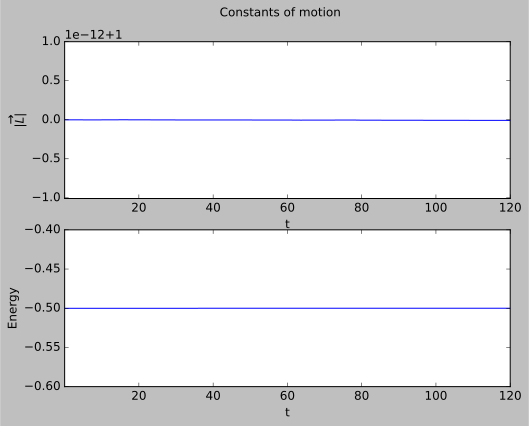

In [17]:
with plt.style.context('classic'): 
    fig, axs = plt.subplots(2)
    fig.suptitle('Constants of motion')

    axs[0].plot(t, L)
    axs[1].plot(t, energy)
    plt.ylim(-0.6, -0.4)

    ylabels = ['$|\overrightarrow{L}|$', 'Energy']
    i = 0
    for ax in axs.flat:
        ax.set(xlabel='t', ylabel=r'{}'.format(ylabels[i]))
        i += 1

## Фазовая плоскость

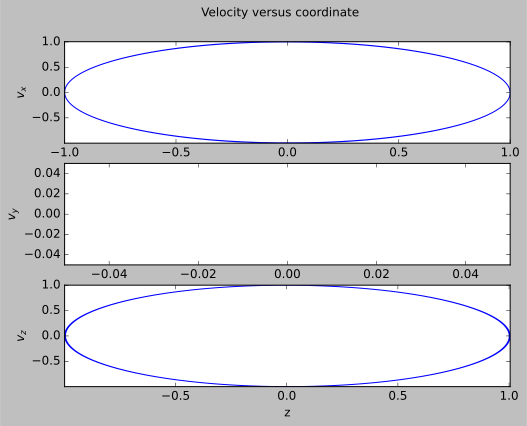

In [18]:
with plt.style.context('classic'): 
    fig, axs = plt.subplots(3)
    fig.suptitle('Velocity versus coordinate')

    axs[0].plot(x, vx)
    axs[1].plot(y, vy)
    axs[2].plot(z, vz)

    axs[0].set(xlabel='x', ylabel=r'$v_x$')
    axs[1].set(xlabel='y', ylabel=r'$v_y$')
    axs[2].set(xlabel='z', ylabel=r'$v_z$')

## Траектории по координатам

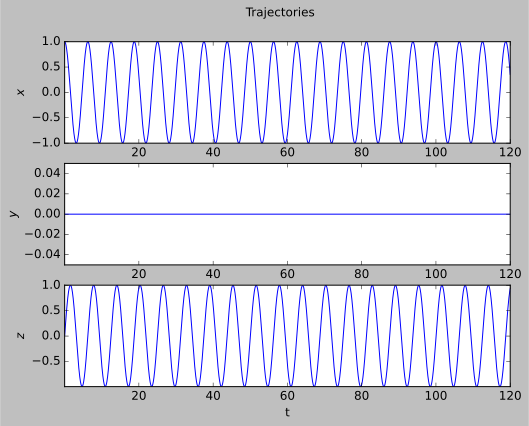

In [19]:
with plt.style.context('classic'): 
    fig, axs = plt.subplots(3)
    fig.suptitle('Trajectories')

    axs[0].plot(t, x)
    axs[1].plot(t, y)
    axs[2].plot(t, z)

    axs[0].set(xlabel='t', ylabel=r'$x$')
    axs[1].set(xlabel='t', ylabel=r'$y$')
    axs[2].set(xlabel='t', ylabel=r'$z$')

## Траектория

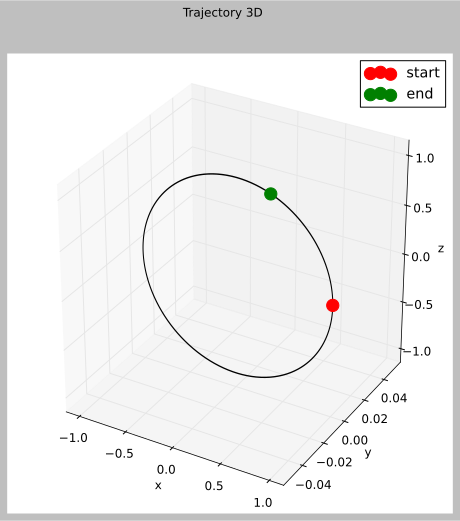

In [20]:
with plt.style.context('classic'): 
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle('Trajectory 3D')


    ax.scatter(x[0], y[0], z[0], s=150, color='red', label='start')

    ax.scatter(x[-1], y[-1], z[-1], s=150, color='green', label='end')

    ax.plot3D(x, y, z, 'black')
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    ax.legend()